<a href="https://colab.research.google.com/github/Neil-Kloper/Prostate-cANcer-graDe-Assessment-PANDA-Challenge/blob/master/Densenet_169_round_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 17kB/s 
     |████████████████████████████████| 4.0MB 49.7MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [2]:
import numpy as np 
import pandas as pd 
import os

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
import torch
import torch.nn as nn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
train[['primary Gleason', 'secondary Gleason']] = train.gleason_score.str.split('+',expand=True)
display(train.head())

pd.set_option('mode.chained_assignment', None)

train['id'] = train['image_id'] + '.jpeg'
train_isup = train[['id', 'isup_grade']]
train_primary = train[['id', 'primary Gleason']]
train_secondary = train[['id', 'secondary Gleason']]

train_isup['isup_grade'] = train_isup['isup_grade'].astype(int)


train_isup['grade_1'] = pd.Series([1 if x >= 1 else 0 for x in train_isup['isup_grade']], index=train_isup.index)
train_isup['grade_2'] = pd.Series([1 if x >= 2 else 0 for x in train_isup['isup_grade']], index=train_isup.index)
train_isup['grade_3'] = pd.Series([1 if x >= 3 else 0 for x in train_isup['isup_grade']], index=train_isup.index)
train_isup['grade_4'] = pd.Series([1 if x >= 4 else 0 for x in train_isup['isup_grade']], index=train_isup.index)
train_isup['grade_5'] = pd.Series([1 if x >= 5 else 0 for x in train_isup['isup_grade']], index=train_isup.index)

train_bin = train_isup[['id', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5']]

,image_id,data_provider,isup_grade,gleason_score,primary Gleason,secondary Gleason
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,4,4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0,0


In [6]:
transform = get_transforms(do_flip=True,
                           flip_vert=True,#default False
                           max_rotate=15,
                           max_zoom=1.15,
                           max_lighting=0.15,
                           max_warp=0.25,
                           p_affine=0.5,
                           p_lighting = 0.5, 
                           xtra_tfms= [
# ###                               zoom_crop(scale=(0.75,2), do_rand=True),#currently not working
# ###                               rand_resize_crop(size=224, max_scale=2.0, ratios=(0.75, 1.33)), #currently not working
#                                 rotate(degrees=(-30,30), p=0.75),
#                                 brightness(change=0.5),
# ###                               contrast(scale=1),#currently not working
#                                 crop_pad(size=512, padding_mode='reflection', row_pct=1., col_pct=1.),
#                                 jitter(magnitude=0.03),
# ###                               crop(row_pct=0.5, col_pct=0.5),
#                                 pad(mode='reflection'),
#                                 perspective_warp(magnitude=0.03, invert=False),
#                                 rotate(degrees=0.0),
#                                 rgb_randomize(channel=None, thresh=0.3),
# ###                               skew(direction=1, magnitude=0.03, invert=False), #currently not working
#                                 squish(scale=1.1, row_pct=0.7, col_pct=0.7),
                                symmetric_warp(magnitude=(-0.1,0.1)),
# ###                               tilt(direction=0, magnitude=0, invert=False), #currently not working
#                                 zoom(scale=1.0, row_pct=0.5, col_pct=0.5),
#                                 cutout(n_holes=(4,12), length=(10,40))
                           ]
                          )

In [7]:
path = Path('/content/drive/My Drive/w200_s100_k25/')
data = ImageDataBunch.from_df(path=path,
                              df=train_bin,
                              valid_pct=0.3,
                              label_col=['grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5'],
                              size=686,
                              bs=8,
                              ds_tfms=transform
        ).normalize(imagenet_stats)

In [8]:
learn = cnn_learner(data, models.densenet169, loss_func=nn.BCEWithLogitsLoss(), metrics=[fbeta, accuracy, accuracy_thresh], pretrained=False)
Model_Path = Path('/content/drive/My Drive')
learn.model_dir = Model_Path
learn.load('dense169-checkpoint-2')
learn.model_dir = Model_Path

In [9]:
learn.fit_one_cycle(8, max_lr=1e-4) 

epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time
0,0.375943,0.317441,0.650168,0.627889,0.865075,33:48
1,0.386851,0.331780,0.649693,0.627889,0.849937,14:53
2,0.362817,0.348549,0.640884,0.619095,0.845100,14:57
3,0.352885,0.310160,0.640149,0.608857,0.863002,14:58
4,0.342296,0.303459,0.634660,0.609673,0.871608,14:58
5,0.288642,0.285844,0.644332,0.611934,0.881093,15:06
6,0.289776,0.278604,0.647838,0.613254,0.885616,14:55
7,0.327213,0.277171,0.646640,0.613128,0.883731,15:08


In [10]:
learn.save('dense169-checkpoint-4')

In [11]:
#learn.load('dense169-checkpoint-4'):

epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


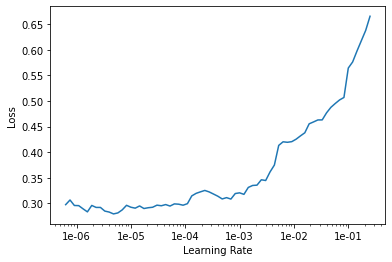

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4), wd=1e-1)

epoch,train_loss,valid_loss,fbeta,accuracy,accuracy_thresh,time
0,0.318499,0.278753,0.645396,0.614196,0.882098,15:05
1,0.310793,0.276424,0.643323,0.609296,0.885364,15:09


In [14]:
learn.save('dense169-checkpoint-5')
print('save!')

save!
